In [3]:
import requests 
import json
import pyodbc 
import numpy as np
from datetime import datetime, timedelta
from requests.auth import HTTPBasicAuth
import time
from datetime import datetime, timedelta
import re
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')


### 1.1 - Data Extract: Live Bugs

In [39]:
cnxn = pyodbc.connect("Driver={SQL Server};"
                          "Server=XXXX;"
                          "Database=XXXX;"
                          "Trusted_Connection=yes;")

query2 = """
        SELECT XXXXX
        FROM XXXXX
        WHERE XXXXX
"""
CommunityIssue_all = pd.read_sql(query2,cnxn)

CommunityIssue_all['CommunityRegBug dummy'] = 1
CommunityIssue_all.loc[CommunityIssue_all['DEVTrack'] == "Not Regressed Bug" , 'CommunityRegBug dummy'] = 0  

### Add me too count from #rowForcustomfield_36318 > div > strong > label
cnxn.close()

# CommunityIssue.head(10).to_csv('check.csv')

# This one shows the "regressed bugs only" 
# CommunityIssue_bugs = CommunityIssue_all[CommunityIssue_all['CommunityRegBug dummy']==1]
CommunityIssue_bugs = CommunityIssue_all
CommunityIssue_bugs['ExternalID'] = CommunityIssue_bugs['ExternalID'].str.replace("TS4-", "")
CommunityIssue_bugs.rename(columns={'bugid': 'community_id', 'ExternalID':'bugid'}, inplace=True)
CommunityIssue_bugs['bugid'] = CommunityIssue_bugs['bugid'].str.strip()
# CommunityIssue_bugs.head(1)
# Label as the affected version

print('Number of regressed bugs is: ', CommunityIssue_bugs['bugid'].count())

print('Number of live bugs is: ', CommunityIssue_bugs['community_id'].count())

# CommunityIssue_bugs['Label'].unique()

Number of regressed bugs is:  3242
Number of live bugs is:  6017


### 1.2 - Finding the pack bugs belong to. 

In [45]:
# Using the label to find the pack
substring = 'ep'
CommunityIssue_bugs['Label'].fillna('ep?', inplace=True)
# CommunityIssue_bugs.to_csv('community_issues_labelcheck.csv')
CommunityIssue_bugs['Contains_Substring'] = CommunityIssue_bugs['Label'].str.lower().str.contains(substring)
CommunityIssue_bugs_eps = CommunityIssue_bugs[CommunityIssue_bugs['Contains_Substring']]

# CommunityIssue_bugs_eps.head(1)
CommunityIssue_bugs_eps['community_id'].count()

4110


### 2. Preparing the input data. 
#### 2.1. Here you should define "n" to search for packs. All the eligible packs before the packs to project.

In [139]:
# Define the set of substrings to search for
n = 16
pack = 'EP16'

In [52]:
packs = pd.Series([f'EP{i:02d}' for i in range(1, n)])
# print(packs)
for substring in packs:
     mask = CommunityIssue_bugs_eps['Label'].str.contains(substring, case=False)
     CommunityIssue_bugs_eps.loc[mask, 'Pack'] = substring

# CommunityIssue_bugs_eps.head(1)

CommunityIssue_bugs_eps['Pack'].fillna('NA', inplace=True)
# CommunityIssue_bugs_eps.dropna(subset=['Pack'], inplace=True)

print(CommunityIssue_bugs_eps['Pack'].unique())
CommunityIssue_bugs_eps['community_id'].count()

CommunityIssue_bugs_eps.head(1)

print('Number of bugs per pack: \n')
CommunityIssue_bugs_eps.groupby(['Pack'])['community_id'].count().reset_index(name='# Bugs')

['EP13' 'NA' 'EP12' 'EP11' 'EP09' 'EP01' 'EP10' 'EP08' 'EP07' 'EP14'
 'EP15']
Number of bugs per pack: 



,Pack,# Bugs
0,EP01,1
1,EP07,9
2,EP08,93
3,EP09,1
4,EP10,3
5,EP11,153
6,EP12,155
7,EP13,81
8,EP14,61
9,EP15,87


#### 2.2. The packs with less than 10 bugs are removed from the df. Packs = ['EP01', 'EP07', 'EP09', 'EP10', 'NA']

In [35]:
Packs_excl = ['EP01', 'EP07', 'EP09', 'EP10', 'NA']  # 
CommunityIssue_bugs_eps = CommunityIssue_bugs_eps[~CommunityIssue_bugs_eps.Pack.isin(Packs_excl)]

#### Creating some date times
CommunityIssue_bugs_eps['Created_date'] = pd.to_datetime(CommunityIssue_bugs_eps['CreatedTime_UTC']).dt.date
CommunityIssue_bugs_eps.head(1)

CommunityIssue_bugs_eps['Created_year'] = pd.to_datetime(CommunityIssue_bugs_eps['Created_date']).dt.year
CommunityIssue_bugs_eps['Created_month'] = pd.to_datetime(CommunityIssue_bugs_eps['Created_date']).dt.month
CommunityIssue_bugs_eps['Created_week_of_month'] = (pd.to_datetime(CommunityIssue_bugs_eps['Created_date']).dt.day - 1) // 7 + 1
CommunityIssue_bugs_eps['Created_week_start'] = pd.to_datetime(CommunityIssue_bugs_eps['Created_date']).dt.to_period('W').apply(lambda r: r.start_time)

# CommunityIssue_bugs_daily = CommunityIssue_bugs_eps.groupby(['Pack', 'Created_date'])['community_id'].count().reset_index(name='# Bugs')
# This one does not seem ok! ", 'Created_week_of_month' "
CommunityIssue_bugs_daily = CommunityIssue_bugs_eps.\
                        groupby(['Pack', 'Created_date', 'Created_week_start', 'Created_year', 'Created_month'])['community_id'].\
                        count().reset_index(name='# Bugs')

# CommunityIssue_bugs_daily.to_csv('CommunityIssue_bugs_daily.csv', index=True)
print('List of packs for training: \n', CommunityIssue_bugs_daily['Pack'].unique())
CommunityIssue_bugs_daily.tail(10)

List of packs for training: 
 ['EP08' 'EP11' 'EP12' 'EP13' 'EP14' 'EP15']


,Pack,Created_date,Created_week_start,Created_year,Created_month,# Bugs
164,EP15,2024-01-30,2024-01-29,2024,1,2
165,EP15,2024-02-15,2024-02-12,2024,2,1
166,EP15,2024-02-19,2024-02-19,2024,2,1
167,EP15,2024-02-21,2024-02-19,2024,2,1
168,EP15,2024-03-04,2024-03-04,2024,3,2
169,EP15,2024-03-07,2024-03-04,2024,3,1
170,EP15,2024-03-11,2024-03-11,2024,3,1
171,EP15,2024-03-15,2024-03-11,2024,3,1
172,EP15,2024-06-18,2024-06-17,2024,6,1
173,EP15,2024-07-11,2024-07-08,2024,7,1


#### 2.3. Here you should define a data frame according to the upcoming pack information. This will be appended to the input df.  
#### The projection is going to be for the five weeks after the launch date, so add the dates accordingly.

In [76]:
## Try to append a df for the upcoming pack. 
d = {'Pack': ['EP16', 'EP16', 'EP16', 'EP16', 'EP16'], 
     'Created_date': ['2024-07-25', '2024-08-02', '2024-08-09', '2024-08-16', '2024-08-24'], 
     'Created_week_start' : ['2024-07-25', '2024-08-02', '2024-08-09', '2024-08-16', '2024-08-24'],
     'Created_year' : [2024, 2024, 2024, 2024, 2024],
     'Created_month' : [7, 7, 8, 8, 8],
     '# Bugs': [0, 0, 0, 0, 0]
    }
     
CommunityIssue_bugs_pack = pd.DataFrame(data=d)
# CommunityIssue_bugs_pack.head(10)

# CommunityIssue_bugs_daily.append(CommunityIssue_bugs_pack)
CommunityIssue_bugs_daily = pd.concat([CommunityIssue_bugs_daily, CommunityIssue_bugs_pack])
# CommunityIssue_bugs_daily.tail()

#### 2.4. Importing "Effort hours" and "No of features" data. Please update the input files by appending upcoming pack data. 

In [78]:
## Features
features = pd.read_csv(r"C:\Users\bshakeri\Electronic Arts\Sims 4 QV [EAHY] - Documents\Projection Materials\Live Ops Projection\Input\Features_per_Packs.csv")
#features.head()
features['ShipDate'] = pd.to_datetime(features['ShipDate'])

## Efforts 
efforts = pd.read_csv(r"C:\Users\bshakeri\Electronic Arts\Sims 4 QV [EAHY] - Documents\Projection Materials\Live Ops Projection\Input\Hours_per_Packs.csv")
#efforts.head()


d1 = pd.merge(features, efforts, on = 'Pack', how = 'inner')

d2 = pd.merge(d1, CommunityIssue_bugs_daily,  on = 'Pack', how = 'right')

print(d2.columns)
print(d2['Pack'].unique())

# d2.tail(10)

Index(['Pack', 'ShipDate', 'Features', 'Testing efforts', 'Created_date',
       'Created_week_start', 'Created_year', 'Created_month', '# Bugs'],
      dtype='object')
['EP08' 'EP11' 'EP12' 'EP13' 'EP14' 'EP15' 'EP16']


#### 2.5. Final input dataset

In [121]:
## Only considering the bugs happen after the release date (6 buckets..)

d2['Created_date'] = pd.to_datetime(d2['Created_date'])
d2['ShipDate'] = pd.to_datetime(d2['ShipDate'])

# Calculate the difference in weeks between date and ship_date
# d2['weeks_after_ship'] = ((d2['Created_date'] - d2['ShipDate']).dt.days // 7 + 1).astype(int)
# d2['weeks_after_ship'] = d2['weeks_after_ship'].apply(lambda x: 1 if x <= 0 else x)
# d2 = d2[(d2['weeks_after_ship']<=5) & (d2['weeks_after_ship']>=0)]
# # d2['DateDifference'] = (d2['ShipDate'] - d2['Created_date']).dt.days


d2['DateDifference'] = (pd.to_datetime(d2['Created_date']) - pd.to_datetime(d2['ShipDate'])).dt.days
# Create a new column 'weeks_after_ship' based on the conditions
d2['weeks_after_ship'] = pd.cut(d2['DateDifference'],
                         bins=[-float('inf'), 6, 13, 20, 27, 34, float('inf')], # 
                         labels=[1, 2, 3, 4, 5, 6]).astype(int)                 # ,6  

# Calculate the end of the week date
d2['EndOfWeek'] = pd.to_datetime(d2['ShipDate']) + pd.to_timedelta(d2['weeks_after_ship'] * 7, unit='D')
d2['StartOfWeek'] = pd.to_datetime(d2['ShipDate']) + pd.to_timedelta((d2['weeks_after_ship']-1) * 7, unit='D')

d2_final = d2.groupby(['Pack', 'ShipDate','Features', 'Testing efforts', 'StartOfWeek'])['# Bugs'].sum().reset_index()
d2_final.rename(columns = {'StartOfWeek': 'Created_week_start'}, inplace=True)

d2_final.tail(2)

,Pack,ShipDate,Features,Testing efforts,Created_week_start,# Bugs
37,EP16,2024-07-25,69,10873,2024-08-15,0
38,EP16,2024-07-25,69,10873,2024-08-22,0


### 3. Check the correlation between the input variables and actual bugs

In [123]:
correlation = d2_final['# Bugs'].corr(d2_final['Testing efforts'])
print(f"The correlation between Weekly number of bugs and Testing efforts is {correlation:.2f}")

The correlation between Weekly number of bugs and Testing efforts is -0.09


In [125]:
correlation = d2_final['# Bugs'].corr(d2_final['Features'])
print(f"The correlation between Weekly number of bugs and Features is {correlation:.2f}")

The correlation between Weekly number of bugs and Features is -0.16


### 4. New EP Release Prediction: Prophet 
#### Install and adding the necessary py. packages. 

In [127]:
# pip install prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.utilities import regressor_coefficients
import matplotlib.pyplot as plt
# from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse

#### 4.1. Considering adding Features and Testing efforts as the regressors and validate the numbers.
#### Make sure that the df_train and df_test get the correct set of packs. 

16:00:30 - cmdstanpy - INFO - Chain [1] start processing


Number of weeks in train data: 34
Number of weeks in test data: 5


16:00:31 - cmdstanpy - INFO - Chain [1] done processing


0    60.841677
1    36.670095
2    20.981679
3    13.572713
4    15.764422
Name: yhat, dtype: float64
RMSE: 34
          ds       yhat  yhat_lower  yhat_upper
0 2024-07-25  60.841677   48.401237   73.482184
1 2024-08-01  36.670095   23.927025   49.540771
2 2024-08-08  20.981679    8.576424   34.417085
3 2024-08-15  13.572713    0.516347   26.025416
4 2024-08-22  15.764422    3.071809   28.550410


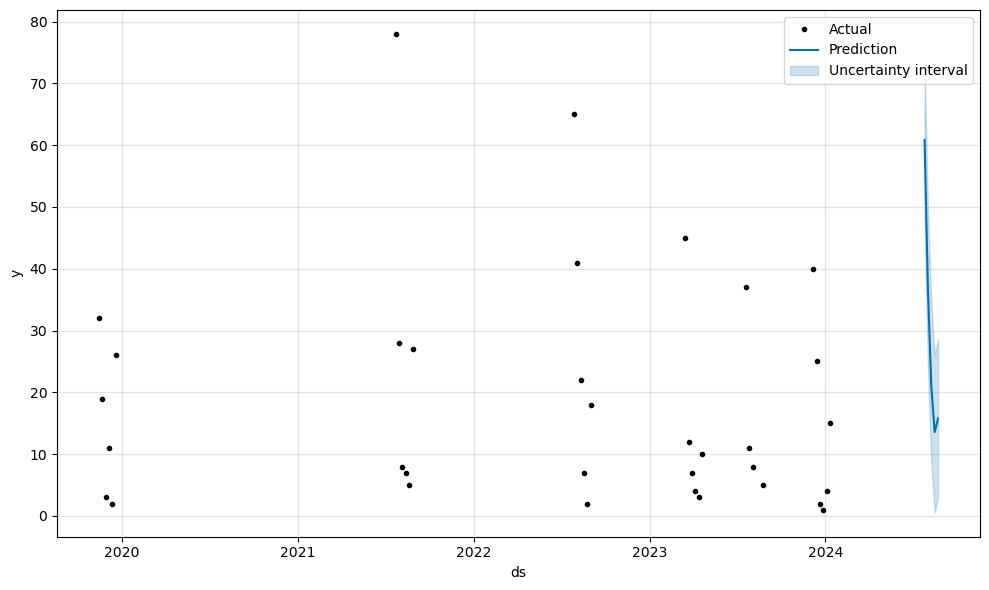

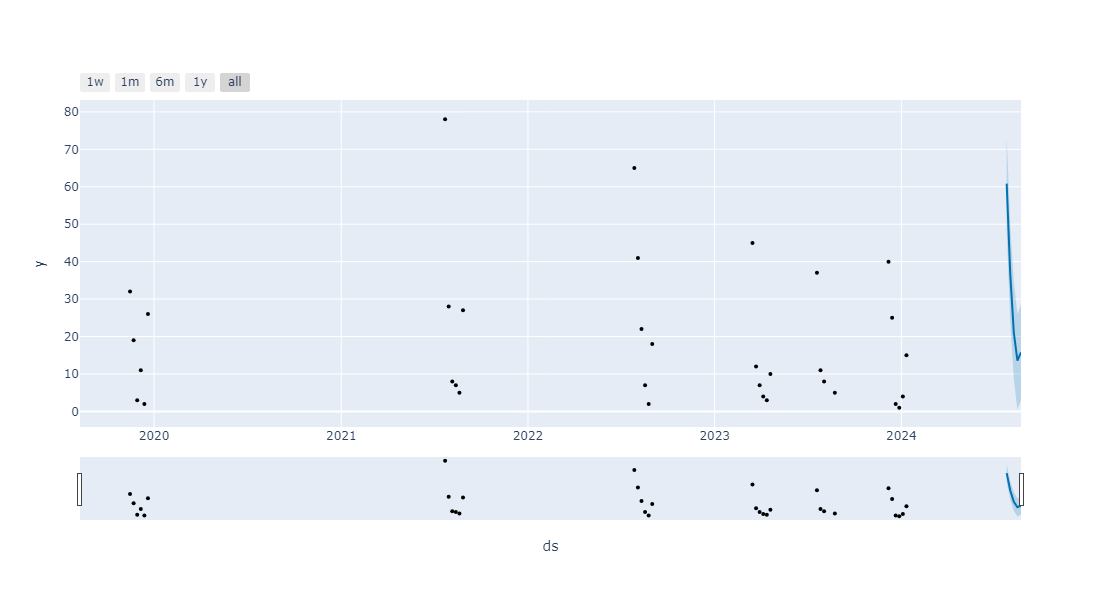

In [161]:
model_name =  'FB_Prophet_Regressors'

d2_prophet = d2_final[['Created_week_start', 'Pack', 'Features', 'Testing efforts', '# Bugs']]
d2_prophet.rename(columns={'Created_week_start': 'ds', '# Bugs':'y'}, inplace=True)
d2_prophet.head()

############ Test and train split
# 'EP11' 'EP12' 'EP13' 'EP14' 
# split data 
d2_train = d2_prophet[d2_prophet['Pack'].isin(['EP08', 'EP11', 'EP12', 'EP13', 'EP14', 'EP15'])].drop('Pack', axis=1) # -- 'EP08', 
d2_test = d2_prophet[d2_prophet['Pack'].isin(['EP16'])].drop('Pack', axis=1)

print(f"Number of weeks in train data: {len(d2_train)}")
print(f"Number of weeks in test data: {len(d2_test)}")


############ Check the numbers based on adding or removing the regressors
model = Prophet(changepoint_prior_scale=0.009)  #seasonality_prior_scale=10
# model.add_regressor('Features')  # , prior_scale=0.5, mode='multiplicative'
model.add_regressor('Testing efforts')


model.fit(d2_train) #d2_prophet

### This is used for test/validation.
future = d2_test.drop(['y'], axis=1)  # d2_prophet

# future = model.make_future_dataframe(periods=5, freq='W')
forecast = model.predict(future)

predictions = forecast.iloc[-len(d2_test):]['yhat']
actuals = d2_test['y']
print(predictions)
print(f"RMSE: {round(rmse(predictions, actuals))}")

## Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

data = pd.DataFrame(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
data.to_csv(r'C:\Users\bshakeri\Electronic Arts\Sims 4 QV [EAHY] - Documents\Projection Materials\Live Ops Projection\Output\{pack}_live_Estimate_{model}.csv'\
            .format(pack=pack, model=model_name), 
            index=False)

fig = model.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

plot_plotly(model, forecast)

#### 4.2. New EP Release Prediction: Prophet 
#### Only considering actual bugs as the time series since the there is very weak relations between the actual bugs and the regressors

16:01:05 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing


Number of weeks in train data: 34
Number of weeks in test data: 5
0    49.837002
1    24.408161
2    13.495873
3     8.350013
4     5.518706
Name: yhat, dtype: float64
RMSE: 26
          ds       yhat  yhat_lower  yhat_upper
0 2024-07-25  49.837002   35.151101   65.280458
1 2024-08-01  24.408161    9.594886   39.923267
2 2024-08-08  13.495873   -1.319474   28.846319
3 2024-08-15   8.350013   -6.432845   23.412135
4 2024-08-22   5.518706  -10.066223   20.699842


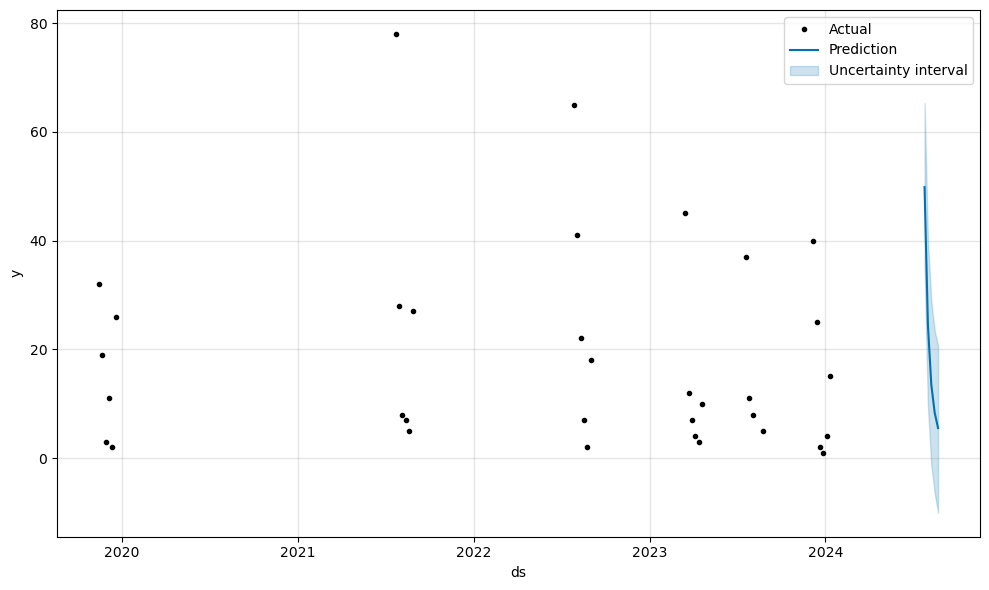

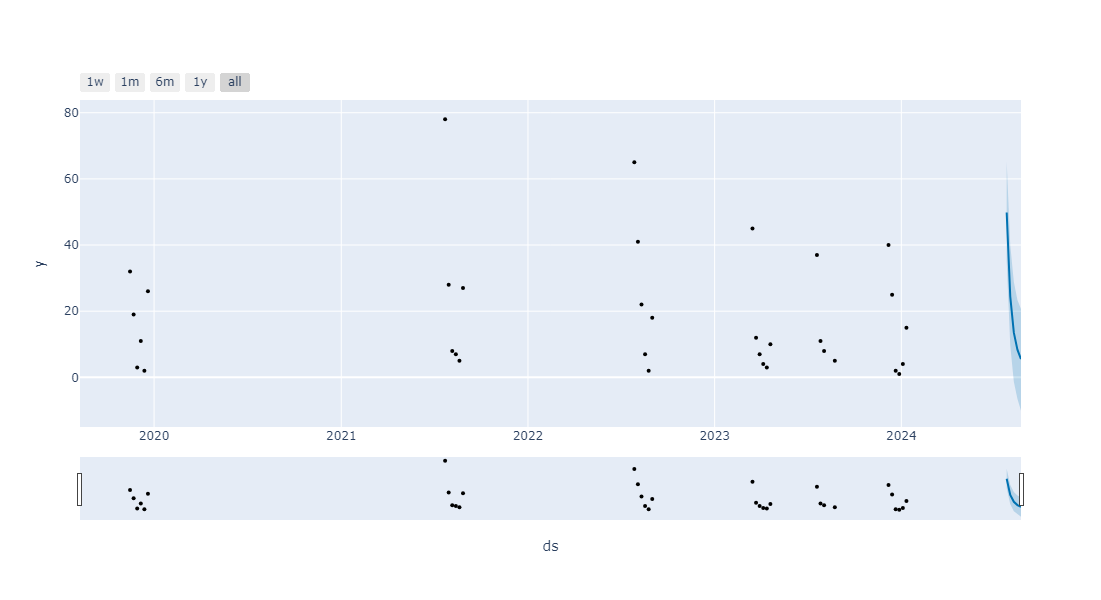

In [163]:
model_name =  'FB_Prophet_Vanila'

d2_prophet = d2_final[['Created_week_start', 'Pack', '# Bugs']]
d2_prophet.rename(columns={'Created_week_start': 'ds', '# Bugs':'y'}, inplace=True)

# ########### Test and train split
d3_train = d2_prophet[d2_prophet['Pack'].isin(['EP08', 'EP11', 'EP12', 'EP13', 'EP14', 'EP15'])].drop('Pack', axis=1) 
d3_test = d2_prophet[d2_prophet['Pack'].isin(['EP16'])].drop('Pack', axis=1)

print(f"Number of weeks in train data: {len(d3_train)}")
print(f"Number of weeks in test data: {len(d3_test)}")

new_model = Prophet()  # seasonality_prior_scale
new_model.fit(d3_train) #d2_prophet

### This is used for test/validation.
future = d3_test.drop(['y'], axis=1)  # d2_prophet

# future = model.make_future_dataframe(periods=5, freq='W')
forecast = new_model.predict(future)

predictions = forecast.iloc[-len(d3_test):]['yhat']
actuals = d3_test['y']
print(predictions)
print(f"RMSE: {round(rmse(predictions, actuals))}")

## Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

data = pd.DataFrame(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
data.to_csv(r'C:\Users\bshakeri\Electronic Arts\Sims 4 QV [EAHY] - Documents\Projection Materials\Live Ops Projection\Output\{pack}_live_Estimate_{model}.csv'\
            .format(pack=pack, model=model_name), 
            index=False)

fig = model.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

plot_plotly(model, forecast)